<a href="https://www.kaggle.com/code/phammaianh/pollutants?scriptVersionId=233233295" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_2.cpg
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_3.shx
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_0.cpg
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_3.shp
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_0.shx
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_1.dbf
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_0.prj
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_3.cpg
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_1.shp
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_0.shp
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_1.prj
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_1.shx
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_2.shx
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_3.dbf
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_1.cpg
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_2.dbf
/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_2.prj
/kaggle/input/

# 🧪 Air Pollution Analysis in Vietnam (2021–2024)
## 📌 Overview
Briefly describe:

**Objective:** To analyze air pollutants like O₃, NO₂, CO, CH₄ across Vietnamese provinces (e.g., North and South regions).

**Data sources:** Mention shapefile, TIFF raster files from satellite data.

**Time period:** 2021–2024.

# 📌 Part 1: Setup and Configuration

In [2]:
!pip install geopandas rasterio rasterstats pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.7 MB/s eta 0:00:00


In [3]:
# Install required packages (if needed)
# !pip install geopandas rasterstats

# Imports
import os
import numpy as np
import geopandas as gpd
import pandas as pd
from datetime import datetime
from rasterstats import zonal_stats
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import re
from scipy.ndimage import zoom
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm.notebook import tqdm  # best for Jupyter/Kaggle Notebook interface

# 🌍 Part 2: Define Regions and Paths

In [4]:
# === Define Regions ===

# Northern provinces
northern_provinces = [
    "Hải Phòng", "Thái Bình", "Nam Định", "Hải Dương", "Ninh Bình",
    "Hưng Yên", "Bắc Ninh", "Hà Nam", "Vĩnh Phúc", "Hà Nội",
    "Quảng Ninh", "Thái Nguyên", "Bắc Giang", "Phú Thọ", "Tuyên Quang",
    "Bắc Kạn", "Hà Giang", "Cao Bằng", "Lạng Sơn", "Điện Biên",
    "Lai Châu", "Sơn La", "Lào Cai", "Hoà Bình", "Yên Bái"
]

southern_provinces = [
    "An Giang", "Bà Rịa - Vũng Tàu", "Bạc Liêu", "Bến Tre", "Bình Dương",
    "Bình Phước", "Cà Mau", "Cần Thơ", "Đồng Nai", "Đồng Tháp", "Hậu Giang",
    "Hồ Chí Minh", "Kiên Giang", "Long An", "Sóc Trăng", "Tây Ninh", "Tiền Giang",
    "Trà Vinh", "Vĩnh Long"
]

# === Define Paths ===

shapefile = "/kaggle/input/vietnam-map/gadm41_VNM_shp/gadm41_VNM_1.shp"
tif_folder = "/kaggle/input/pollutants-hanoi/Pollutants/O3"
years = [2021, 2022, 2023, 2024]
pollutants = ["CH4", "CO", "NO2", "O3"]

# 🧱 Part 3: Define Core Functions

## 🔧 Core Function Suite Design
### 1. load_and_filter_shapefile
- Purpose: Load shapefile and select valid geometries for target provinces.

- Inputs: shapefile_path, selected_provinces

- Returns: GeoDataFrame

### 2. clip_rasters_to_provinces
- Purpose: Clip each .tif to the boundary of selected provinces for visualization (optional but useful).

- Inputs: raster_path, gdf_selected

- Returns: Clipped raster_array, metadata (e.g. extent, transform, CRS)

### 3. process_raster_files
- Purpose: Read each raster.

- Compute: Mean pollutant value per province (zonal stats) Number of valid (non-nodata) days per province.

- Returns: Long-form DataFrame with: Province, Date, Month, Pollutant_Mean, Days_Available

### 4. analyze_and_pivot_data
- Purpose: Convert long-form data to pivot tables: Monthly averages Yearly averages Total days with valid data

- Returns: Pivoted DataFrame

### 5. box_plot_pollutant_distribution
- Purpose: Box plot of monthly pollutant values

- Inputs: Long-form DataFrame

### 6. line_plot_pollutant_trend
- Purpose: Line plot of pollutant trends over time

- Inputs: Aggregated data (province-level, month-level)

### 7. visualize_pollution_map
- Purpose: Display clipped raster values on a map

- Inputs: Clipped raster + shapefile

- Tools: matplotlib, rasterio, contextily (for basemaps)

In [5]:
# 1. Load and filter shapefile

def load_and_filter_shapefile(shapefile_path, selected_provinces, region_column="NAME_1"):
    gdf = gpd.read_file(shapefile_path)
    gdf_filtered = gdf[gdf[region_column].isin(selected_provinces)].copy()
    gdf_filtered = gdf_filtered[gdf_filtered.geometry.is_valid]
    return gdf_filtered

In [6]:
# 2. Clip raster to selected provinces (optional for visual map)
def clip_and_average_rasters(tif_files, clip_geom, target_crs):
    import rasterio
    from rasterio.mask import mask
    import numpy as np
    import geopandas as gpd

    data_stack = []
    transform = None
    crs = None

    for tif_file in tif_files:
        with rasterio.open(tif_file) as src:
            # Reproject geometry if needed
            if src.crs != target_crs:
                gdf_temp = gpd.GeoDataFrame(geometry=clip_geom, crs=target_crs)
                gdf_temp = gdf_temp.to_crs(src.crs)
                clip_geom_reprojected = [gdf_temp.unary_union]
            else:
                clip_geom_reprojected = clip_geom

            # Clip and mask
            clipped, out_transform = mask(src, clip_geom_reprojected, crop=True)
            array = clipped[0].astype(float)

            # Handle nodata values
            if src.nodata is not None:
                array[array == src.nodata] = np.nan

            data_stack.append(array)

            # Store metadata
            if transform is None:
                transform = out_transform
                crs = src.crs

    mean_data = np.nanmean(np.stack(data_stack), axis=0)
    return mean_data, transform, crs

In [7]:
def process_raster_files(tif_folder, gdf_selected, region_column="NAME_1"):
    print("\n🛰️ STEP 2: Processing raster files...")
    records = []
    tif_files = sorted([f for f in os.listdir(tif_folder) if f.endswith(".tif")])

    for file in tqdm(tif_files, desc="⏳ Processing TIFFs"):
        try:
            file_path = os.path.join(tif_folder, file)

            with rasterio.open(file_path) as src:
                if src.crs is None:
                    tqdm.write(f"❌ Skipping {file}: No CRS defined.")
                    continue
                raster_crs = src.crs

            # Reproject provinces to match raster CRS
            gdf_projected = gdf_selected.to_crs(raster_crs)

            # Extract date
            date_str = file.split("_")[-1].replace(".tif", "")
            date = datetime.strptime(date_str, "%Y%m%d")
            month = date.month

            # ✅ Convert geometries to GeoJSON features
            geojson_features = [mapping(geom) for geom in gdf_projected.geometry]

            # Zonal statistics using raw geometries
            stats = zonal_stats(
                geojson_features,
                file_path,
                stats="mean",
                nodata=-999,
                all_touched=True
            )

            for j, stat in enumerate(stats):
                records.append({
                    "Province": gdf_projected.iloc[j][region_column],
                    "Month": month,
                    "Date": date,
                    "Mean_O3": stat.get("mean", None)
                })

        except Exception as e:
            tqdm.write(f"❌ Skipping file {file}: {e}")
            continue

    print(f"📦 Processed {len(records)} records.")
    return pd.DataFrame(records)

In [8]:
# 4. Analyze and pivot data
def analyze_and_pivot_data(df, value_column):
    tqdm.write("📊 STEP 4: Analyzing and pivoting data...")

    # Ensure numeric data
    tqdm.write("🔢 Converting data to numeric...")
    df[value_column] = pd.to_numeric(df[value_column], errors="coerce")

    # Grouping by Province and Month
    tqdm.write("📈 Calculating monthly averages per province...")
    monthly_avg = df.groupby(["Province", "Month"])[value_column].mean().reset_index()

    # Pivot table
    tqdm.write("📊 Pivoting data...")
    pivot_df = monthly_avg.pivot(index="Province", columns="Month", values=value_column)
    pivot_df.columns = [f"Month_{m}" for m in pivot_df.columns]

    # Annual average
    tqdm.write("📅 Calculating annual averages per province...")
    pivot_df["Annual_Avg"] = pivot_df.mean(axis=1, skipna=True)

    # Add overall monthly averages and annual average
    tqdm.write("➕ Appending overall monthly and annual averages...")
    monthly_means = pivot_df.drop(columns="Annual_Avg").mean()
    pivot_df.loc["Averages"] = list(monthly_means) + [pivot_df["Annual_Avg"].mean()]

    tqdm.write("✅ Analysis complete.")
    return pivot_df

In [9]:
# 5. Bar plot
def plot_annual_avg_bar(shapefile, tif_folder, region_names, years, region_column="NAME_1", verbose=True):
    print("📍 Loading shapefile...")
    gdf = gpd.read_file(shapefile)
    gdf = gdf[gdf[region_column].isin(region_names)]
    if gdf.empty:
        print(f"❌ None of the regions {region_names} found in column '{region_column}'")
        return

    gdf = gdf[gdf.geometry.is_valid]
    clip_geom = [gdf.unary_union]

    year_means = []

    for year in tqdm(years, desc="Processing years"):
        tif_files = sorted([
            os.path.join(tif_folder, f)
            for f in os.listdir(tif_folder)
            if f.endswith(".tif") and f"O3_composite_{year}" in f
        ])
        if not tif_files:
            year_means.append(np.nan)
            continue

        try:
            mean_data, _, _ = clip_and_average_rasters(tif_files, clip_geom, gdf.crs)
            if mean_data is not None:
                mean_data = np.where(mean_data == 0, np.nan, mean_data)
                avg_value = np.nanmean(mean_data)
                year_means.append(avg_value)
            else:
                year_means.append(np.nan)
        except:
            year_means.append(np.nan)

    # Bar plot
    plt.figure(figsize=(8, 6))
    bars = plt.bar([str(y) for y in years], year_means, color="skyblue")
    plt.xlabel("Year")
    plt.ylabel("O₃ Annual Average Concentration")
    plt.title(f"O₃ Annual Average")

    for bar, value in zip(bars, year_means):
        if not np.isnan(value):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{value:.6f}",
                     ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    plt.show()

def plot_monthly_grouped_bar(shapefile, tif_folder, region_names, years, region_column="NAME_1", verbose=True):
    import calendar

    print("📍 Loading shapefile...")
    gdf = gpd.read_file(shapefile)
    gdf = gdf[gdf[region_column].isin(region_names)]
    if gdf.empty:
        print(f"❌ None of the regions {region_names} found in column '{region_column}'")
        return

    gdf = gdf[gdf.geometry.is_valid]
    clip_geom = [gdf.unary_union]

    # Store monthly means
    monthly_data = {year: [np.nan] * 12 for year in years}

    print("📅 Aggregating monthly data...")
    all_files = [f for f in os.listdir(tif_folder) if f.endswith(".tif") and "O3_composite_" in f]

    for year in tqdm(years):
        for month in range(1, 13):
            monthly_files = []
            for fname in all_files:
                match = re.search(r"O3_composite_(\d{8})", fname)
                if match:
                    date_str = match.group(1)
                    try:
                        date_obj = datetime.strptime(date_str, "%Y%m%d")
                        if date_obj.year == year and date_obj.month == month:
                            monthly_files.append(os.path.join(tif_folder, fname))
                    except:
                        continue

            if not monthly_files:
                continue

            try:
                mean_data, _, _ = clip_and_average_rasters(monthly_files, clip_geom, gdf.crs)
                if mean_data is not None:
                    mean_data = np.where(mean_data == 0, np.nan, mean_data)
                    monthly_data[year][month - 1] = np.nanmean(mean_data)
            except:
                continue

    # Plotting
    print("📊 Plotting grouped bar chart...")
    months = [calendar.month_abbr[i] for i in range(1, 13)]
    x = np.arange(len(months))
    width = 0.2
    offset = -((len(years) - 1) / 2) * width

    plt.figure(figsize=(14, 6))
    for idx, year in enumerate(sorted(years)):
        month_vals = monthly_data[year]
        plt.bar(x + offset + idx * width, month_vals, width=width, label=str(year))

    plt.xticks(x, months)
    plt.xlabel("Month")
    plt.ylabel("O₃ Monthly Avg Concentration")
    plt.title(f"O₃ Monthly Avg")
    plt.legend(title="Year")

# 6. Box plot
def plot_monthly_boxplot(shapefile, tif_folder, region_names, years, region_column="NAME_1", verbose=True):
    print("📍 Loading shapefile...")
    gdf = gpd.read_file(shapefile)
    gdf = gdf[gdf[region_column].isin(region_names)]
    if gdf.empty:
        print(f"❌ None of the regions {region_names} found in column '{region_column}'")
        return

    gdf = gdf[gdf.geometry.is_valid]
    
    print("📅 Aggregating monthly data by region across years...")
    all_files = [f for f in os.listdir(tif_folder) if f.endswith(".tif") and "O3_composite_" in f]

    monthly_values = []

    for year in tqdm(years):
        for month in range(1, 13):
            monthly_files = []
            for fname in all_files:
                match = re.search(r"O3_composite_(\d{8})", fname)
                if match:
                    date_str = match.group(1)
                    try:
                        date_obj = datetime.strptime(date_str, "%Y%m%d")
                        if date_obj.year == year and date_obj.month == month:
                            monthly_files.append(os.path.join(tif_folder, fname))
                    except:
                        continue

            if not monthly_files:
                continue

            try:
                for _, row in gdf.iterrows():
                    clip_geom = [row.geometry]
                    mean_data, _, _ = clip_and_average_rasters(monthly_files, clip_geom, gdf.crs)
                    if mean_data is not None:
                        mean_data = np.where(mean_data == 0, np.nan, mean_data)
                        avg_val = np.nanmean(mean_data)
                        if not np.isnan(avg_val):
                            monthly_values.append({
                                "Region": row[region_column],
                                "Year": str(year),
                                "Month": f"{month:02d}",
                                "Concentration": avg_val * 1000  # scale for visibility
                            })
            except:
                continue

    if not monthly_values:
        print("⚠️ No data available for plotting.")
        return

    df = pd.DataFrame(monthly_values)

    # Plot
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df, x="Month", y="Concentration", color="skyblue", fliersize=3)
    
    plt.title("O₃ Monthly Concentration Distribution Across Regions & Years", fontsize=14, weight="bold")
    plt.xlabel("Month")
    plt.ylabel("O₃ Concentration (×10⁻³)")
    plt.tight_layout()
    plt.show()

# 7. Line plot
def line_plot_pollutant_trend(df, pollutant_column):
    tqdm.write(f"📈 STEP 6: Creating line plot to show {pollutant_column} trend over time...")
    trend = df.groupby(["Date"])[pollutant_column].mean().reset_index()
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=trend, x="Date", y=pollutant_column)
    plt.title(f"📅 Trend of {pollutant_column} Over Time")
    plt.tight_layout()
    plt.show()
    tqdm.write("✅ Line plot displayed.")

# 8. Visualize pollution map
def plot_pixel_maps(shapefile, tif_folder, region_names, years, region_column="NAME_1", verbose=True):
    print("📍 Loading shapefile...")
    gdf = gpd.read_file(shapefile)
    gdf = gdf[gdf[region_column].isin(region_names)]
    if gdf.empty:
        print(f"❌ None of the regions {region_names} found in column '{region_column}'")
        return

    gdf = gdf[gdf.geometry.is_valid]
    clip_geom = [gdf.unary_union]

    print("📊 Scanning rasters to determine vmin and vmax...")
    all_means = []
    for year in years:
        tif_files = sorted([
            os.path.join(tif_folder, f)
            for f in os.listdir(tif_folder)
            if f.endswith(".tif") and f"O3_composite_{year}" in f
        ])
        try:
            mean_data, _, _ = clip_and_average_rasters(tif_files, clip_geom, gdf.crs)
            if mean_data is not None:
                mean_data = np.where(mean_data == 0, np.nan, mean_data)
                all_means.append(mean_data)
        except:
            continue

    if not all_means:
        print("⚠️ No valid data found for vmin/vmax calculation.")
        return

    all_data = np.stack(all_means)
    vmin, vmax = np.nanmin(all_data), np.nanmax(all_data)

    print(f"🎯 Auto-scaled vmin = {vmin:.3f}, vmax = {vmax:.3f}")

    fig, axs = plt.subplots(1, len(years), figsize=(5 * len(years), 6))
    if len(years) == 1:
        axs = [axs]  # Make it iterable
    else:
        axs = axs.flatten()

    cmap = 'jet'

    for i, year in enumerate(tqdm(years, desc="Plotting maps")):
        tif_files = sorted([
            os.path.join(tif_folder, f)
            for f in os.listdir(tif_folder)
            if f.endswith(".tif") and f"O3_composite_{year}" in f
        ])

        if not tif_files:
            axs[i].axis("off")
            continue

        try:
            mean_data, transform, crs = clip_and_average_rasters(tif_files, clip_geom, gdf.crs)
            if mean_data is None:
                axs[i].axis("off")
                continue
        except:
            axs[i].axis("off")
            continue

        mean_data = np.where(mean_data == 0, np.nan, mean_data)

        # Calculate extent from original transform
        xres = transform[0]
        yres = abs(transform[4])
        xmin, ymax = transform[2], transform[5]
        xmax = xmin + xres * mean_data.shape[1]
        ymin = ymax - yres * mean_data.shape[0]
        extent = [xmin, xmax, ymin, ymax]

        ax = axs[i]
        im = ax.imshow(mean_data, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent, interpolation="nearest", aspect="auto")
        gdf.to_crs(crs).boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
        ax.set_title(f"{year}", fontsize=12)
        ax.axis("off")

        cbar = plt.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap=cmap), ax=ax, fraction=0.046, pad=0.01)
        cbar.ax.tick_params(labelsize=8)

    region_str = ", ".join(region_names)
    plt.suptitle(f"O₃ Annual Average Concentration", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()

def plot_monthly_avg_maps_selected_regions(shapefile, tif_folder, years, selected_regions, 
                                           pollutant_name="O3", region_column="NAME_1", scale=1000):
    print("📍 Loading shapefile and selecting regions...")
    gdf = gpd.read_file(shapefile)
    gdf = gdf[gdf[region_column].isin(selected_regions)]
    gdf = gdf[gdf.geometry.is_valid]
    gdf = gdf.to_crs("EPSG:4326")

    fig, axs = plt.subplots(3, 4, figsize=(20, 12))
    axs = axs.flatten()

    month_data = {}
    all_valid_values = []

    month_names = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]

    print("🚀 Starting monthly processing...")
    for month in range(1, 13):
        print(f"\n🗓️  Processing {month_names[month - 1]}...")
        matching_files = []
        for fname in os.listdir(tif_folder):
            if pollutant_name in fname and fname.endswith(".tif"):
                match = re.search(rf"{pollutant_name}_composite_(\d{{8}})", fname)
                if match:
                    date = datetime.strptime(match.group(1), "%Y%m%d")
                    if date.year in years and date.month == month:
                        matching_files.append(os.path.join(tif_folder, fname))

        print(f"   📁 Found {len(matching_files)} files for this month.")

        if not matching_files:
            month_data[month] = None
            print("   ⚠️  No data for this month.")
            continue

        clipped_data = []
        # for fpath in tqdm(matching_files):  # Use tqdm if you want a progress bar
        for fpath in matching_files:
            with rasterio.open(fpath) as src:
                try:
                    out_image, _ = mask(src, gdf.geometry, crop=True)
                    arr = out_image[0].astype(float)
                    arr[arr == 0] = np.nan
                    clipped_data.append(arr)
                except Exception as e:
                    print(f"   ⚠️  Skipping {os.path.basename(fpath)} due to error: {e}")
                    continue

        if not clipped_data:
            month_data[month] = None
            print("   ⚠️  No clipped data for this month.")
            continue

        avg_data = np.nanmean(clipped_data, axis=0)
        avg_data *= scale
        month_data[month] = avg_data
        all_valid_values.extend(avg_data[~np.isnan(avg_data)].flatten())
        print("   ✅ Monthly average calculated.")

    # Calculate vmin and vmax from all valid values
    vmin = np.min(all_valid_values) if all_valid_values else 0
    vmax = np.max(all_valid_values) if all_valid_values else 1
    print(f"\n🎯 Final color scale — vmin: {vmin:.2f}, vmax: {vmax:.2f}")

    print("🖼️  Plotting maps...")
    for i in range(12):
        ax = axs[i]
        month = i + 1
        ax.set_title(month_names[i])
        ax.axis('off')

        if month_data[month] is None:
            continue

        im = ax.imshow(month_data[month], cmap="jet", vmin=vmin, vmax=vmax)
        gdf.boundary.plot(ax=ax, edgecolor="black", linewidth=0.5)

    divider = make_axes_locatable(axs[-1])
    cax = divider.append_axes("right", size="5%", pad=0.1)
    norm = Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cax, orientation="vertical", label=f"{pollutant_name} (×{scale})")

    plt.suptitle(f"Monthly Average Map of {pollutant_name} (Selected Regions)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    print("✅ Plot complete!")

In [10]:
output_column = "Mean_O3"
# 1️⃣ Load and filter shapefile
tqdm.write("🌍 STEP 1: Loading and filtering shapefile...")
gdf_selected = load_and_filter_shapefile(shapefile, northern_provinces)

# 2️⃣ Process raster files
df = process_raster_files(tif_folder, gdf_selected)

# 3️⃣ Analyze and pivot
pivot_df = analyze_and_pivot_data(df, output_column)

# 4️⃣ Display results
print(pivot_df)


🌍 STEP 1: Loading and filtering shapefile...

🛰️ STEP 2: Processing raster files...


⏳ Processing TIFFs:   0%|          | 0/1461 [00:00<?, ?it/s]

📦 Processed 36525 records.
📊 STEP 4: Analyzing and pivoting data...
🔢 Converting data to numeric...
📈 Calculating monthly averages per province...
📊 Pivoting data...
📅 Calculating annual averages per province...
➕ Appending overall monthly and annual averages...
✅ Analysis complete.
              Month_1   Month_2   Month_3   Month_4   Month_5   Month_6  \
Province                                                                  
Bắc Giang    0.111174  0.115026  0.117543  0.126872  0.129195  0.127733   
Bắc Kạn      0.111720  0.115518  0.117898  0.126773  0.128862  0.127723   
Bắc Ninh     0.111194  0.115090  0.117496  0.126828  0.129259  0.127826   
Cao Bằng     0.111993  0.115802  0.118343  0.126914  0.128864  0.127773   
Hoà Bình     0.110727  0.114665  0.117003  0.126123  0.128527  0.127116   
Hà Giang     0.112103  0.115906  0.118274  0.126680  0.128578  0.127561   
Hà Nam       0.110709  0.114622  0.117146  0.126538  0.128847  0.127346   
Hà Nội       0.111217  0.115133  0.117473

📍 Loading shapefile...
📊 Scanning rasters to determine vmin and vmax...
🎯 Auto-scaled vmin = 0.118, vmax = 0.122


Plotting maps:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


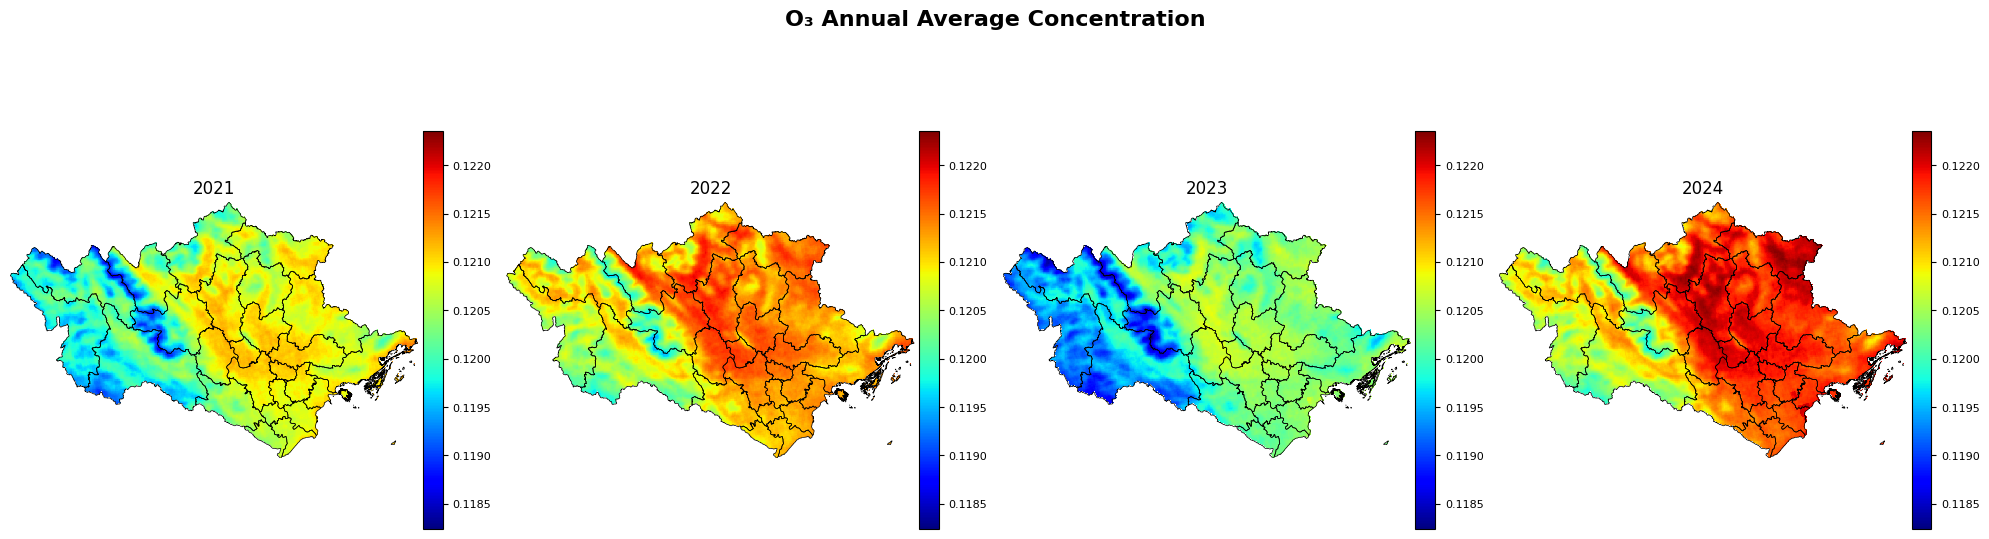

In [11]:
plot_pixel_maps(
    shapefile=shapefile,
    tif_folder=tif_folder,
    region_names=northern_provinces,
    years=years
)

📍 Loading shapefile...


Processing years:   0%|          | 0/4 [00:00<?, ?it/s]

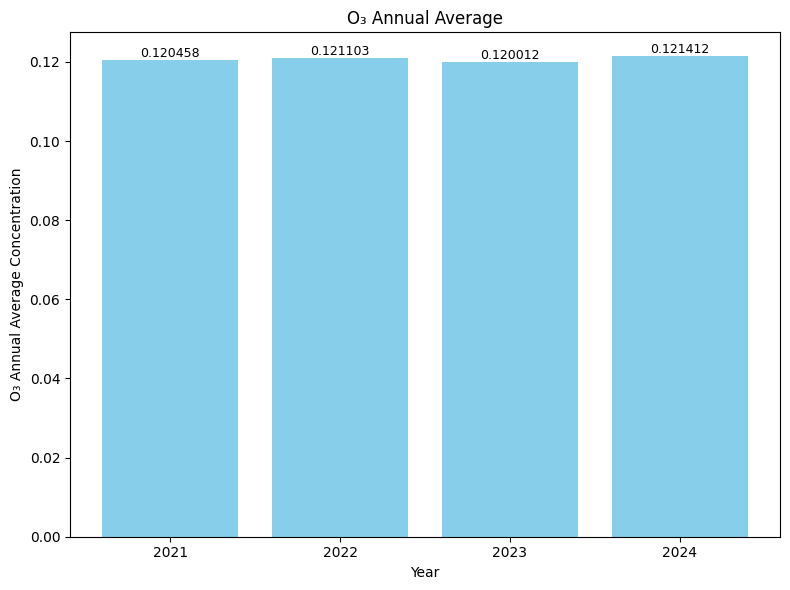

In [12]:
plot_annual_avg_bar(shapefile, tif_folder, northern_provinces, years, region_column="NAME_1")

📍 Loading shapefile...
📅 Aggregating monthly data...


  0%|          | 0/4 [00:00<?, ?it/s]

📊 Plotting grouped bar chart...


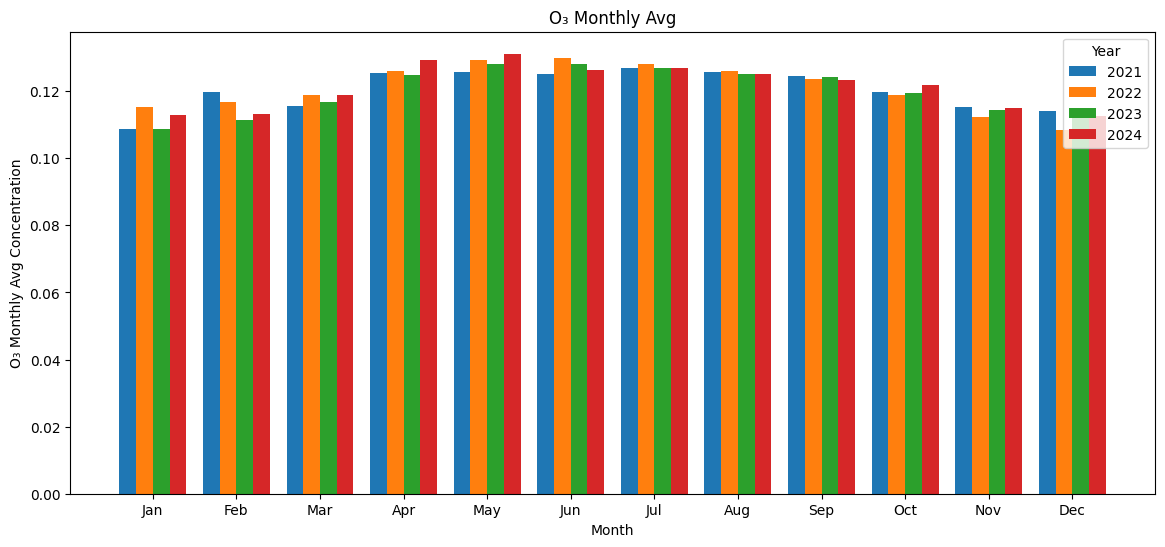

In [13]:
plot_monthly_grouped_bar(shapefile, tif_folder, northern_provinces, years, region_column="NAME_1", verbose=True)

📍 Loading shapefile...
📅 Aggregating monthly data by region across years...


  0%|          | 0/4 [00:00<?, ?it/s]

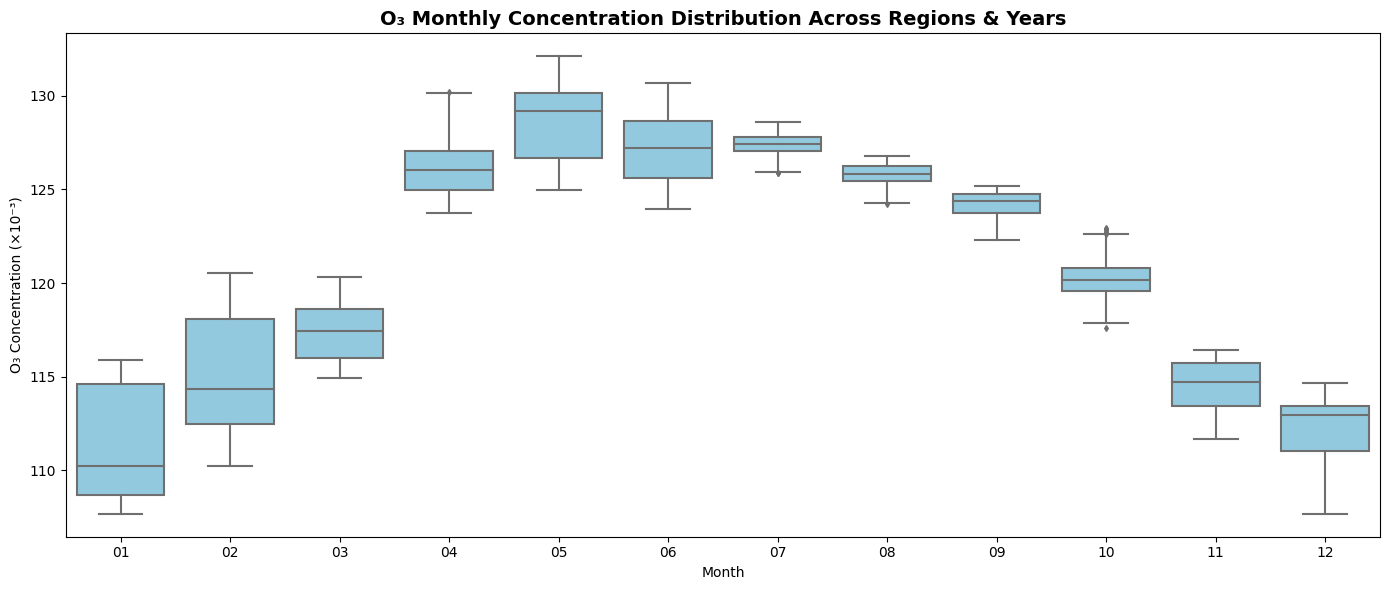

In [14]:
plot_monthly_boxplot(shapefile, tif_folder, northern_provinces, years, region_column="NAME_1", verbose=True)

📍 Loading shapefile and selecting regions...
🚀 Starting monthly processing...

🗓️  Processing January...
   📁 Found 124 files for this month.


<ipython-input-9-007158b41ff6>:335: RuntimeWarning: Mean of empty slice
  avg_data = np.nanmean(clipped_data, axis=0)


   ✅ Monthly average calculated.

🗓️  Processing February...
   📁 Found 113 files for this month.


<ipython-input-9-007158b41ff6>:335: RuntimeWarning: Mean of empty slice
  avg_data = np.nanmean(clipped_data, axis=0)


   ✅ Monthly average calculated.

🗓️  Processing March...
   📁 Found 124 files for this month.


<ipython-input-9-007158b41ff6>:335: RuntimeWarning: Mean of empty slice
  avg_data = np.nanmean(clipped_data, axis=0)


   ✅ Monthly average calculated.

🗓️  Processing April...
   📁 Found 120 files for this month.


<ipython-input-9-007158b41ff6>:335: RuntimeWarning: Mean of empty slice
  avg_data = np.nanmean(clipped_data, axis=0)


   ✅ Monthly average calculated.

🗓️  Processing May...
   📁 Found 124 files for this month.


<ipython-input-9-007158b41ff6>:335: RuntimeWarning: Mean of empty slice
  avg_data = np.nanmean(clipped_data, axis=0)


   ✅ Monthly average calculated.

🗓️  Processing June...
   📁 Found 120 files for this month.


<ipython-input-9-007158b41ff6>:335: RuntimeWarning: Mean of empty slice
  avg_data = np.nanmean(clipped_data, axis=0)


   ✅ Monthly average calculated.

🗓️  Processing July...
   📁 Found 124 files for this month.


<ipython-input-9-007158b41ff6>:335: RuntimeWarning: Mean of empty slice
  avg_data = np.nanmean(clipped_data, axis=0)


   ✅ Monthly average calculated.

🗓️  Processing August...
   📁 Found 124 files for this month.


<ipython-input-9-007158b41ff6>:335: RuntimeWarning: Mean of empty slice
  avg_data = np.nanmean(clipped_data, axis=0)


   ✅ Monthly average calculated.

🗓️  Processing September...
   📁 Found 120 files for this month.


<ipython-input-9-007158b41ff6>:335: RuntimeWarning: Mean of empty slice
  avg_data = np.nanmean(clipped_data, axis=0)


   ✅ Monthly average calculated.

🗓️  Processing October...
   📁 Found 124 files for this month.


<ipython-input-9-007158b41ff6>:335: RuntimeWarning: Mean of empty slice
  avg_data = np.nanmean(clipped_data, axis=0)


   ✅ Monthly average calculated.

🗓️  Processing November...
   📁 Found 120 files for this month.


<ipython-input-9-007158b41ff6>:335: RuntimeWarning: Mean of empty slice
  avg_data = np.nanmean(clipped_data, axis=0)


   ✅ Monthly average calculated.

🗓️  Processing December...
   📁 Found 124 files for this month.


<ipython-input-9-007158b41ff6>:335: RuntimeWarning: Mean of empty slice
  avg_data = np.nanmean(clipped_data, axis=0)


   ✅ Monthly average calculated.

🎯 Final color scale — vmin: 109.82, vmax: 129.84
🖼️  Plotting maps...


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:7

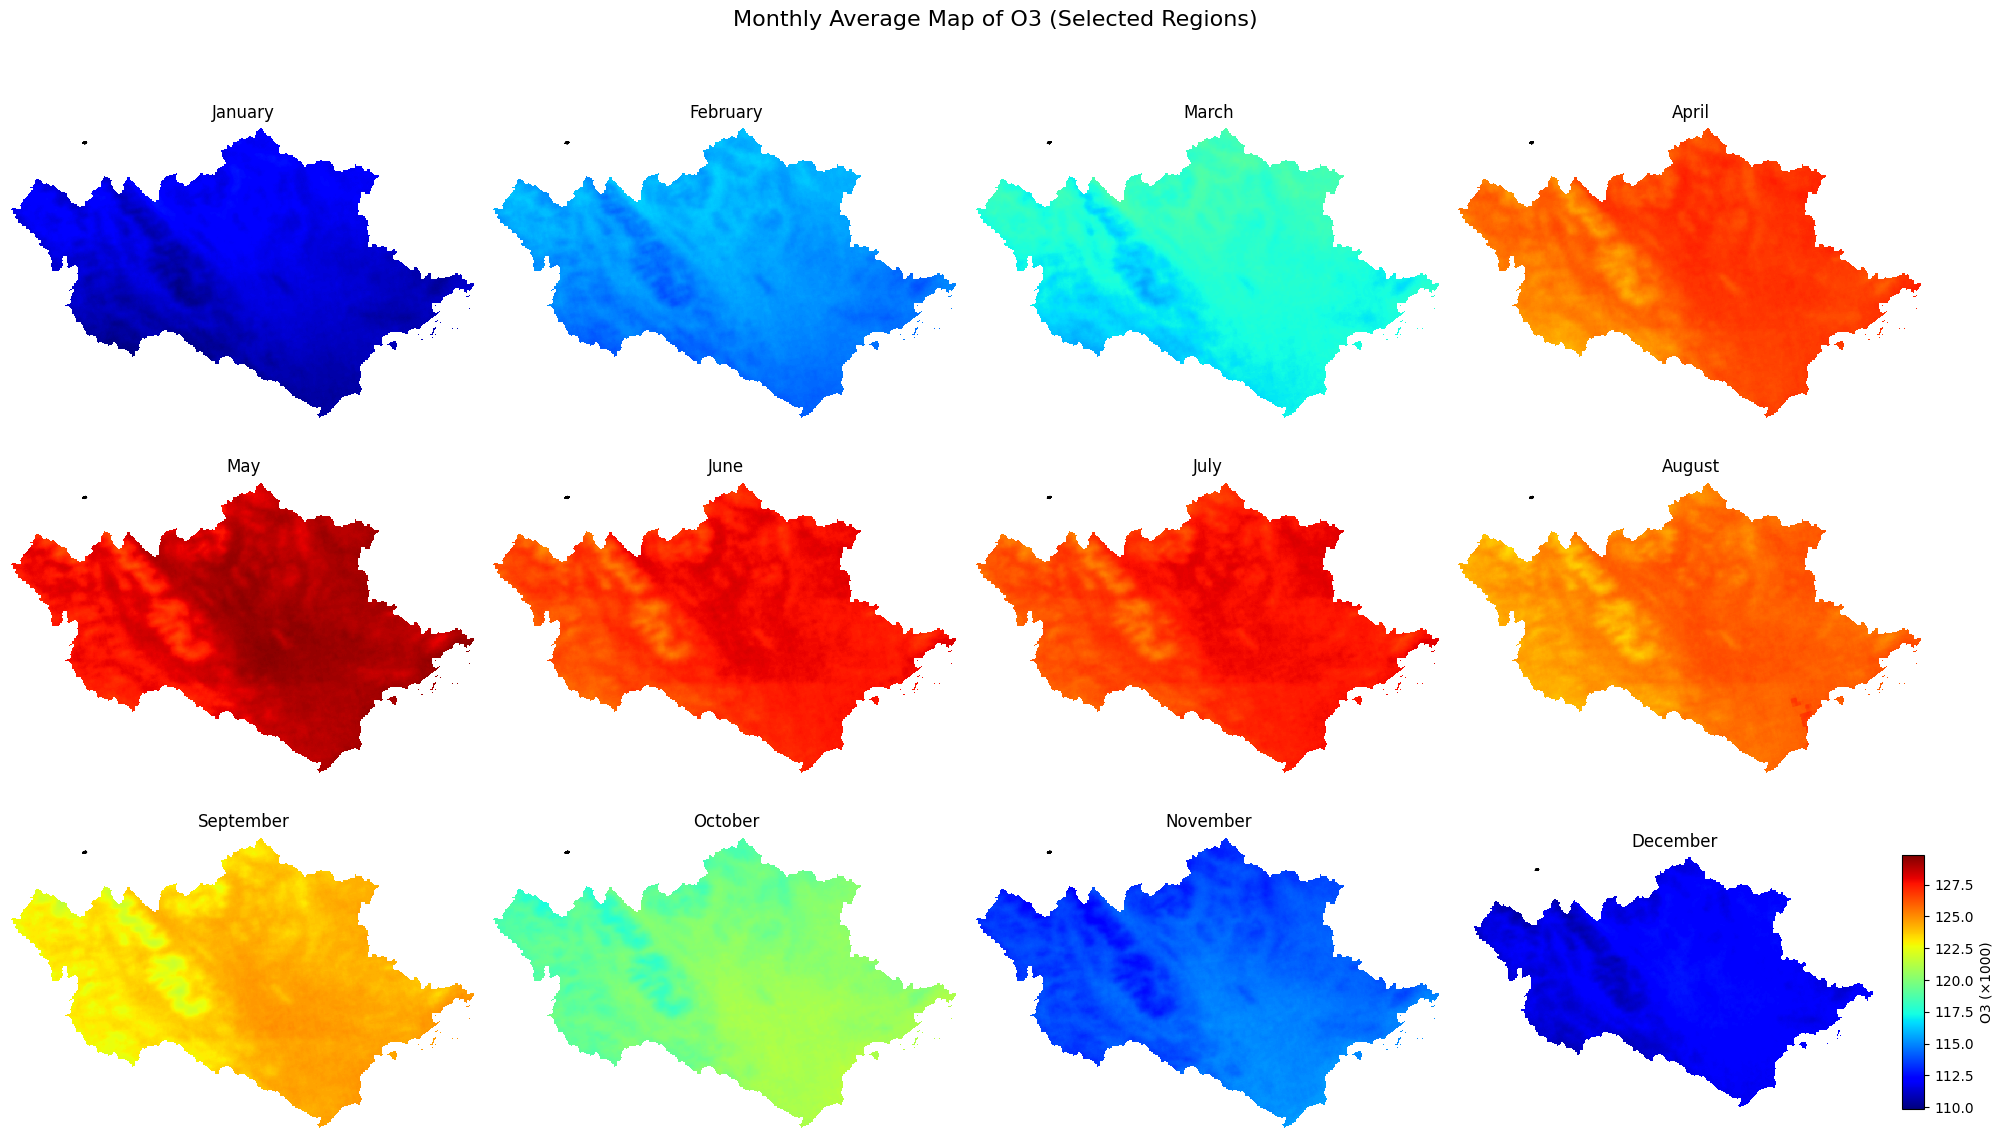

✅ Plot complete!


In [15]:
plot_monthly_avg_maps_selected_regions(
    shapefile=shapefile, 
    tif_folder=tif_folder, 
    years=years, 
    selected_regions=northern_provinces, 
    pollutant_name="O3", 
    region_column="NAME_1", 
    scale=1000
)